In [ ]:
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

# Load data and split the train and test data

In [19]:
data_path = '../data/Risky_driving_behavior.csv' #Risky driving behavior data
oc_path = '../data/Crash_Index.csv' #Crash index data
tf_path = '../data/Traffic_flow_and_risky_driving_behavior.csv' # Aggregated traffic flow and risky driving behavior data
## In aggregated traffic flow and risky driving behavior data, The variable suffixes range from 2 to 6:
## 2: -5min to -10min; 3: -10min to -15min; 4: -15min to -20min; 5: -20min to -20min; 6: -25min to -30min; 

data = pd.read_csv(data_path)
oc = pd.read_csv(oc_path)
tf_data = pd.read_csv(tf_path)

# Delete highly-correlated variables in traffic flow data
delet_col = ["ASD", "ASU", "SSD", "SSU", "DSC", "DSD", "DSU", "AFD", "AFU", "SFD", "BFD", "BFU"]
cols_to_remove = [col for col in tf_data.columns if any(substring in col for substring in delet_col)]
tf_data = tf_data.drop(columns=cols_to_remove)

all_event_id = np.array(data['event_id'].unique())
def inv_list(x):
    d = {}
    for i in range(len(x)):
        d[x[i]] = i
    return d
event_id_to_ind = inv_list(all_event_id)
data['event_id'] = data['event_id'].map(event_id_to_ind)
oc['event_id'] = oc['event_id'].map(event_id_to_ind)

all_event_id = oc['event_id'].unique()
np.random.seed(1018)
np.random.shuffle(all_event_id)
S = len(all_event_id)
bp = int(0.7*S)
train_event_ind = np.sort(all_event_id[:bp])
test_event_ind = np.sort(all_event_id[bp:])

ind_to_event_id = {v: k for k, v in event_id_to_ind.items()} 

decoded_train_event_ids = [ind_to_event_id[ind] for ind in train_event_ind] 
tf_train_data_temp = tf_data.copy()
tf_train_data_temp['event_id'] = pd.Categorical(tf_train_data_temp['event_id'], categories=decoded_train_event_ids, ordered=True) 
tf_train_data = tf_train_data_temp[tf_train_data_temp['event_id'].isin(decoded_train_event_ids)].sort_values('event_id').iloc[:, 1:]

decoded_test_event_ids = [ind_to_event_id[ind] for ind in test_event_ind]
tf_test_data_temp = tf_data.copy()
tf_test_data_temp['event_id'] = pd.Categorical(tf_test_data_temp['event_id'], categories=decoded_test_event_ids, ordered=True)
tf_test_data = tf_test_data_temp[tf_test_data_temp['event_id'].isin(decoded_test_event_ids)].sort_values('event_id').iloc[:, 1:]

# Convert the data into time series data for LSTM

In [20]:
ind_to_event_id = {v: k for k, v in event_id_to_ind.items()} 

decoded_train_event_ids = [ind_to_event_id[ind] for ind in train_event_ind] 
tf_train_data_temp = tf_data.copy()
tf_train_data_temp['event_id'] = pd.Categorical(tf_train_data_temp['event_id'], categories=decoded_train_event_ids, ordered=True) 
tf_train_data = tf_train_data_temp[tf_train_data_temp['event_id'].isin(decoded_train_event_ids)].sort_values('event_id').iloc[:, 1:]

decoded_test_event_ids = [ind_to_event_id[ind] for ind in test_event_ind]
tf_test_data_temp = tf_data.copy()
tf_test_data_temp['event_id'] = pd.Categorical(tf_test_data_temp['event_id'], categories=decoded_test_event_ids, ordered=True)
tf_test_data = tf_test_data_temp[tf_test_data_temp['event_id'].isin(decoded_test_event_ids)].sort_values('event_id').iloc[:, 1:]

n_hours=5
n_features=18+24-len(delet_col)
print(n_features)
n_obs = n_hours * n_features
df1=pd.DataFrame()
df2=pd.DataFrame()

train_y = tf_train_data['Crash']
train_X= tf_train_data.drop('Crash', axis=1)


for i in range(0,n_hours):
    new_column_order = [i + j*n_hours for j in range(0, n_features)]
    df1 = pd.concat([df1, train_X.iloc[:, new_column_order]], axis=1)

feature_names = df1.columns.tolist()

df1 = np.array(df1)
train_X = df1.reshape((train_X.shape[0], n_hours, n_features))

test_y = tf_test_data['Crash']
test_X= tf_test_data.drop('Crash', axis=1)
for i in range(0,n_hours):
    new_column_order = [i + j*n_hours for j in range(0, n_features)]
    df2 = pd.concat([df2, test_X.iloc[:, new_column_order]], axis=1)

df2 = np.array(df2)
test_X = df2.reshape((test_X.shape[0], n_hours, n_features))

test_y=pd.DataFrame(test_y)
train_y=pd.DataFrame(train_y)

y_labels = train_y['Crash'].values
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=y_labels)

def mortality_loss(y_true, y_pred):
    sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
    bce = K.binary_crossentropy(y_true, y_pred)
    return K.mean(sample_weights*bce, axis=-1)

30


# Train LSTM model

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
import time
tf.compat.v1.disable_v2_behavior() 

input_layer = Input(shape=(train_X.shape[1], train_X.shape[2]), name='only_input')

y1 = layers.LSTM(64,return_sequences=False)(input_layer)
y1 = layers.Dense(1, activation='sigmoid')(y1)

model = Model(input_layer, y1)

print(model.summary())

model.compile(optimizer='adam', loss=mortality_loss, metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=50, batch_size=64)
result = model.evaluate(test_X, test_y, verbose=0)
print(result)

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
from tensorflow.keras import backend as K

test_predictions = model.predict(test_X)
test_predictions_binary = (test_predictions > 0.5).astype(int) 

accuracy = accuracy_score(test_y, test_predictions_binary)
recall = recall_score(test_y, test_predictions_binary)
auc = roc_auc_score(test_y, test_predictions)
tn, fp, fn, tp = confusion_matrix(test_y, test_predictions_binary).ravel()
far = fp / (fp + tn)  # False Alarm Rate

print(f"Accuracy on Test Set: {accuracy:.3f}")
print(f"Recall on Test Set: {recall:.3f}")
print(f"FAR on Test Set: {far:.3f}")
print(f"AUC on Test Set: {auc:.3f}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 only_input (InputLayer)     [(None, 5, 30)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                24320     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,385
Trainable params: 24,385
Non-trainable params: 0
_________________________________________________________________
None
Train on 851 samples
Epoch 1/50
851/851 [==============================] - 0s 501us/sample - loss: 0.6670 - acc: 0.6816
Epoch 2/50
851/851 [==============================] - 0s 155us/sample - loss: 0.6243 - acc: 0.7274
Epoch 3/50
851/851 [==============================] - 0s 128us/sample - loss: 0.6063 - acc: 0.7

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Accuracy on Test Set: 0.669
Recall on Test Set: 0.723
FAR on Test Set: 0.346
AUC on Test Set: 0.778


# Crash Risk Influence Variables Explanation based on SHAP

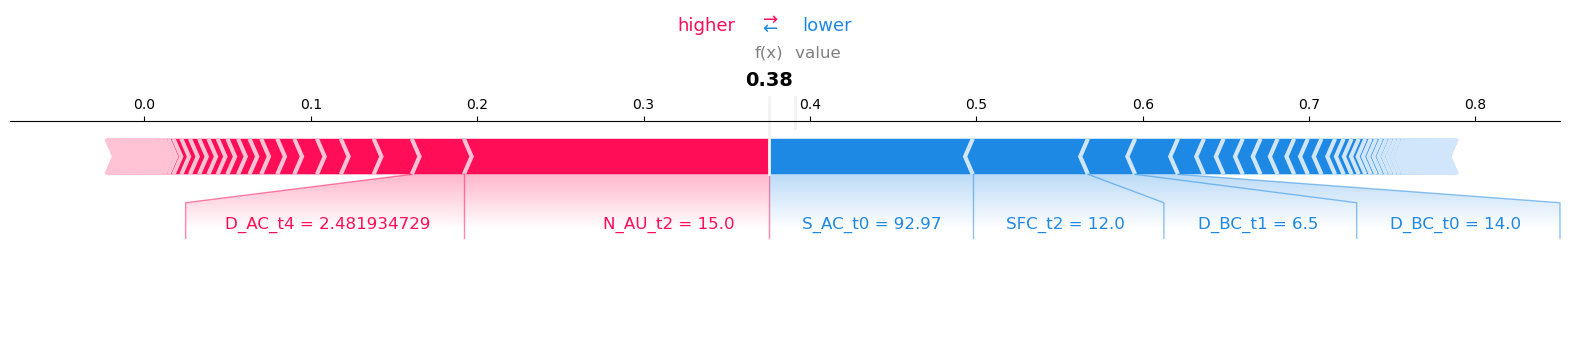

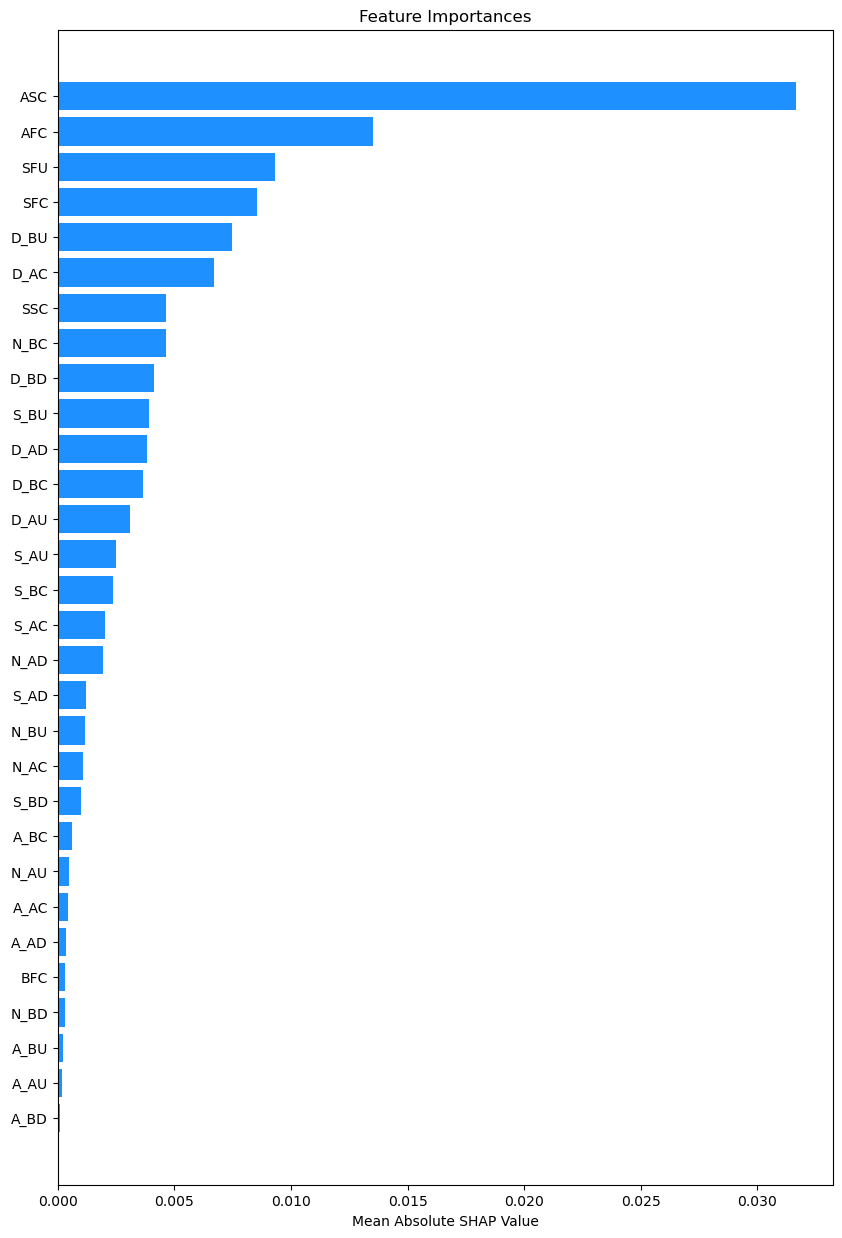

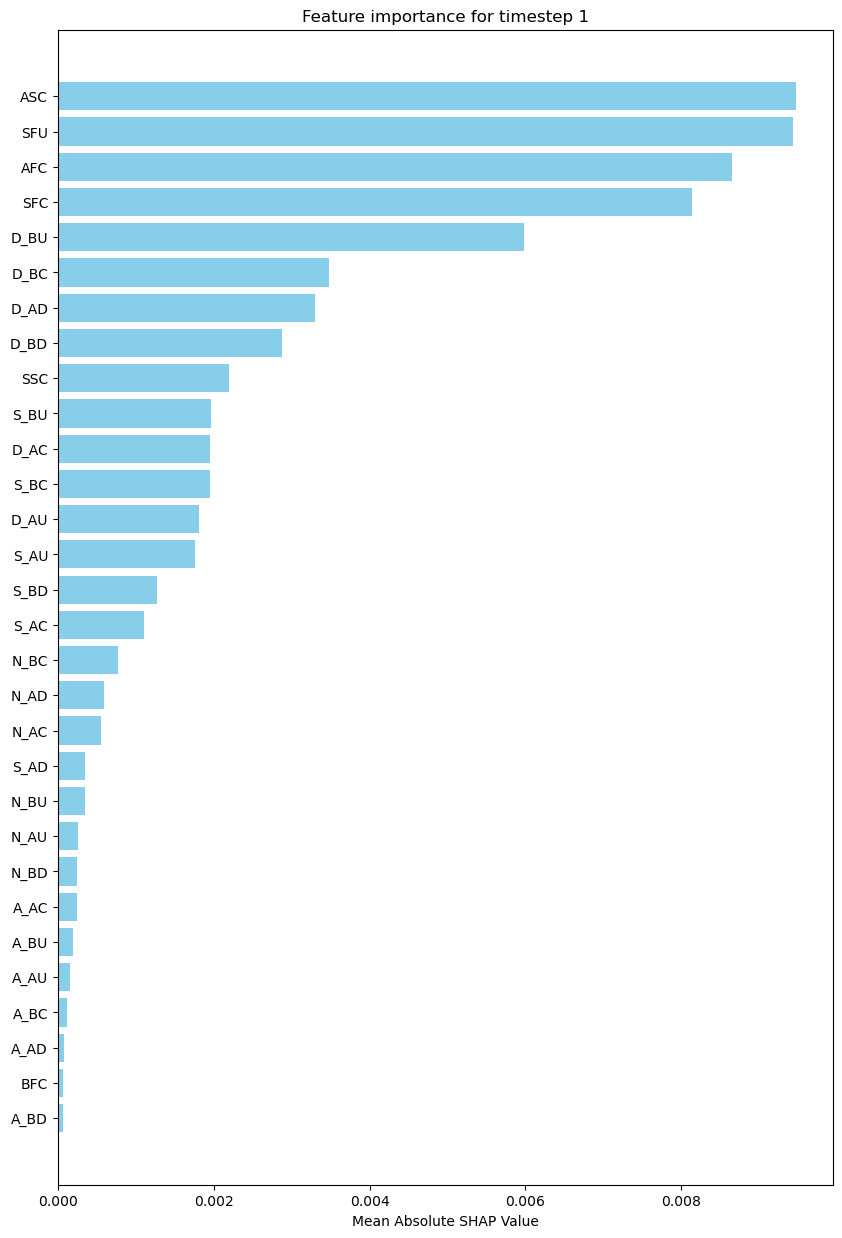

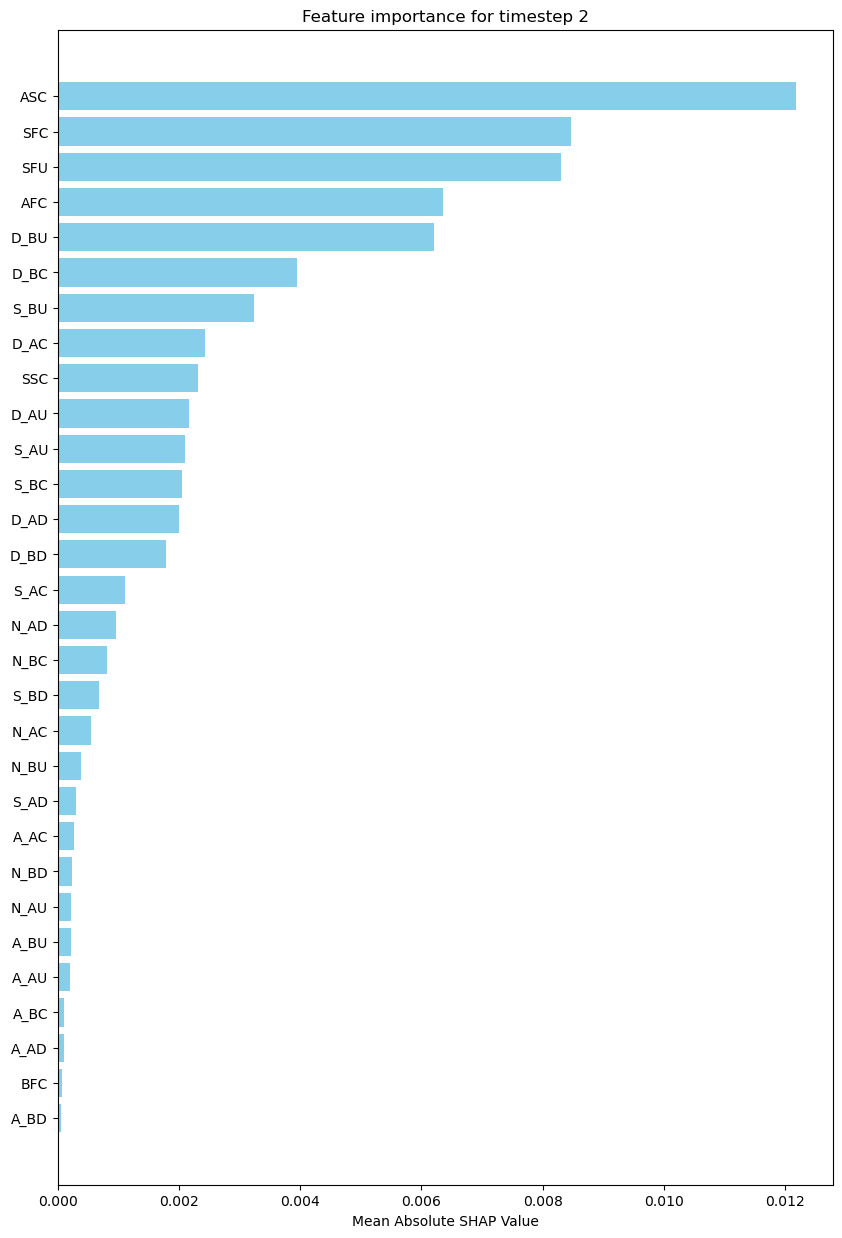

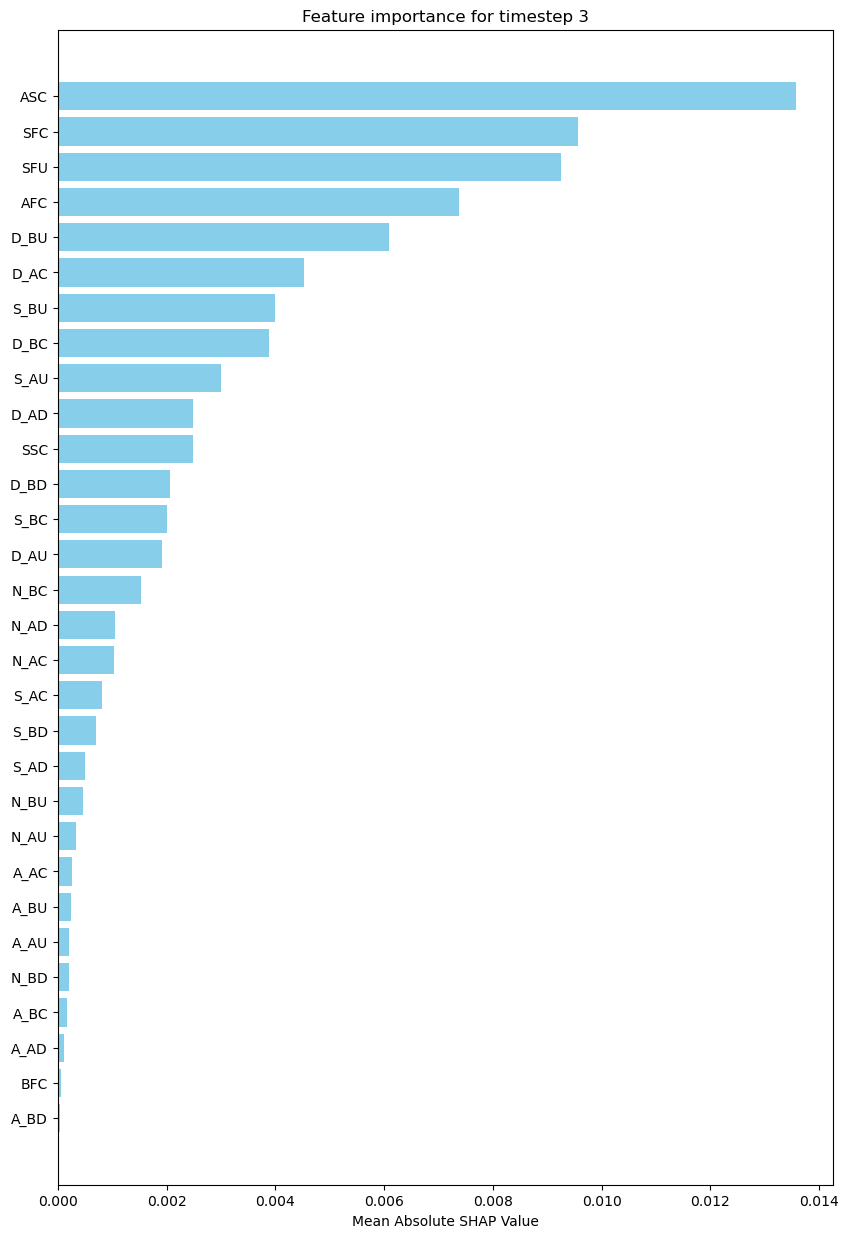

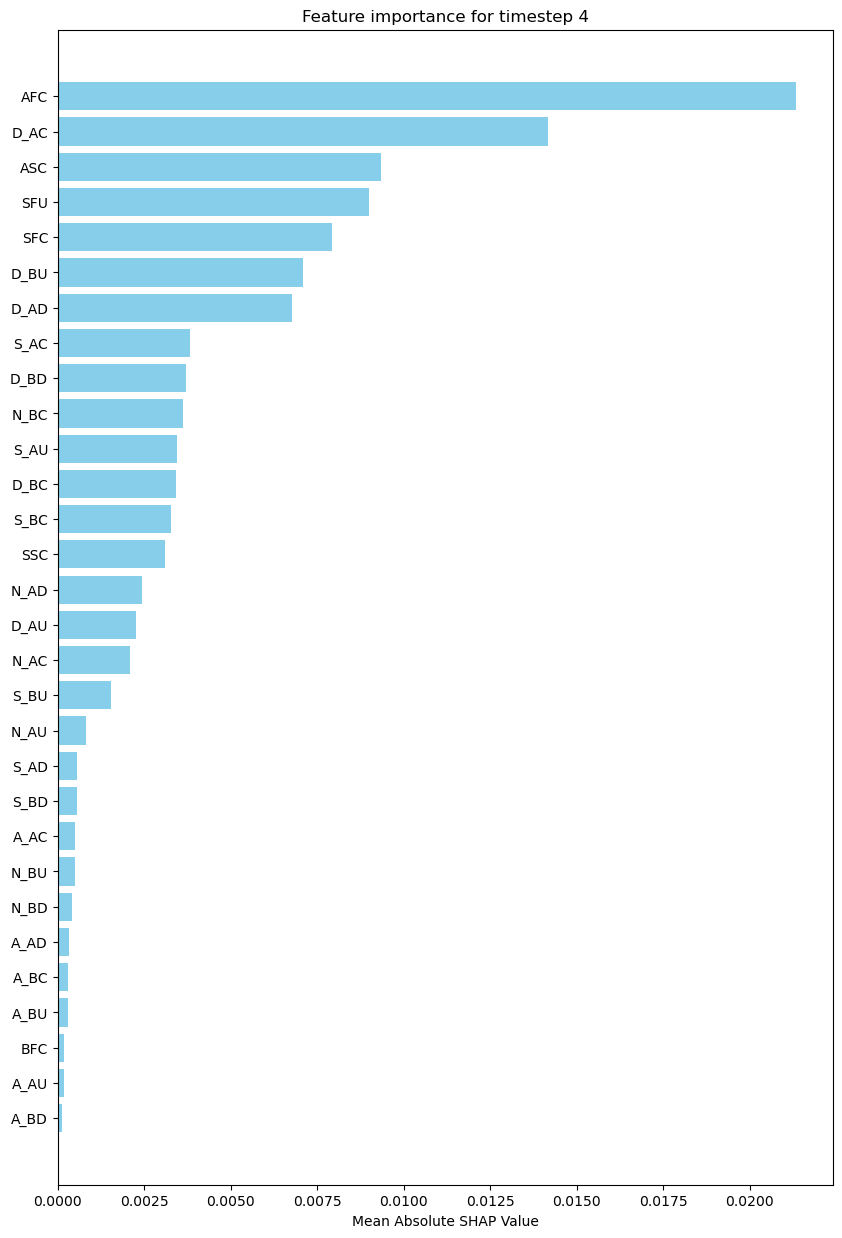

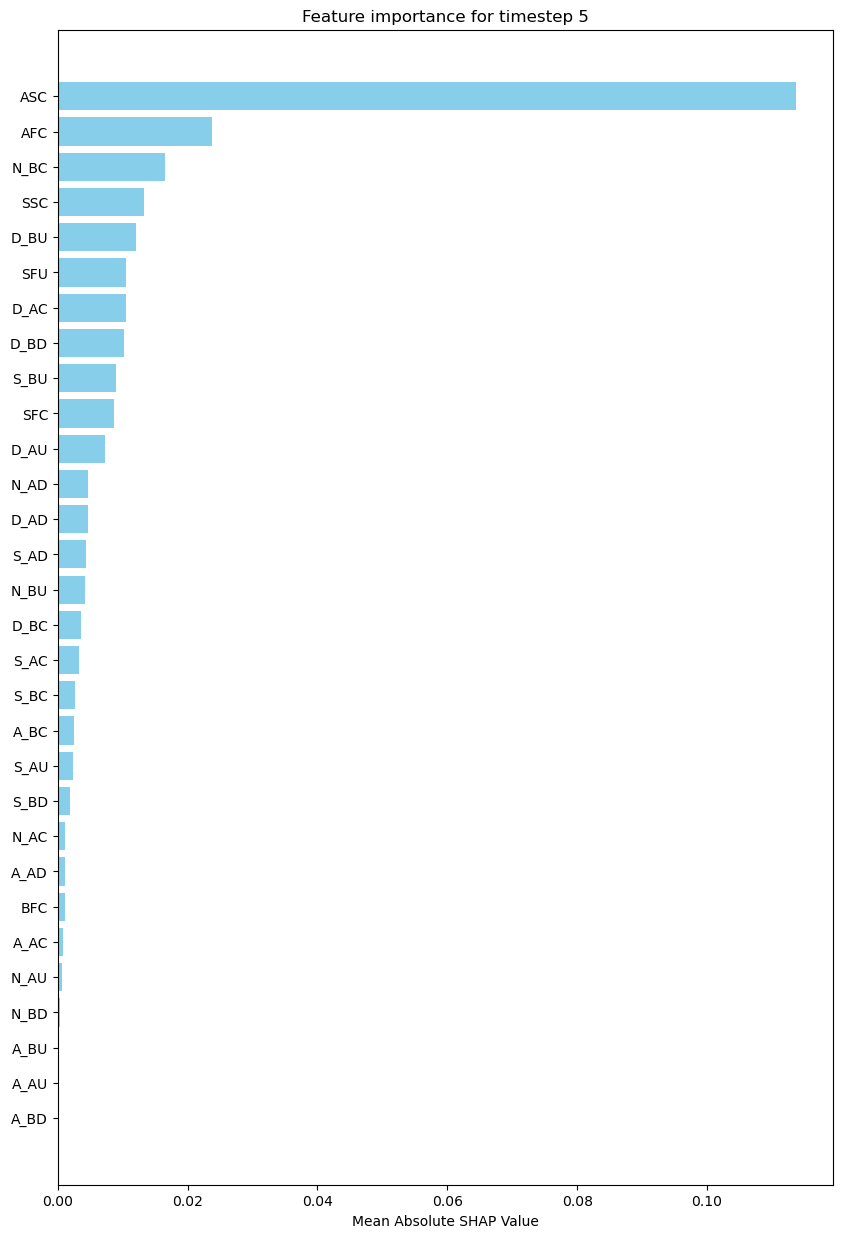

SHAP Summary for timestep 1


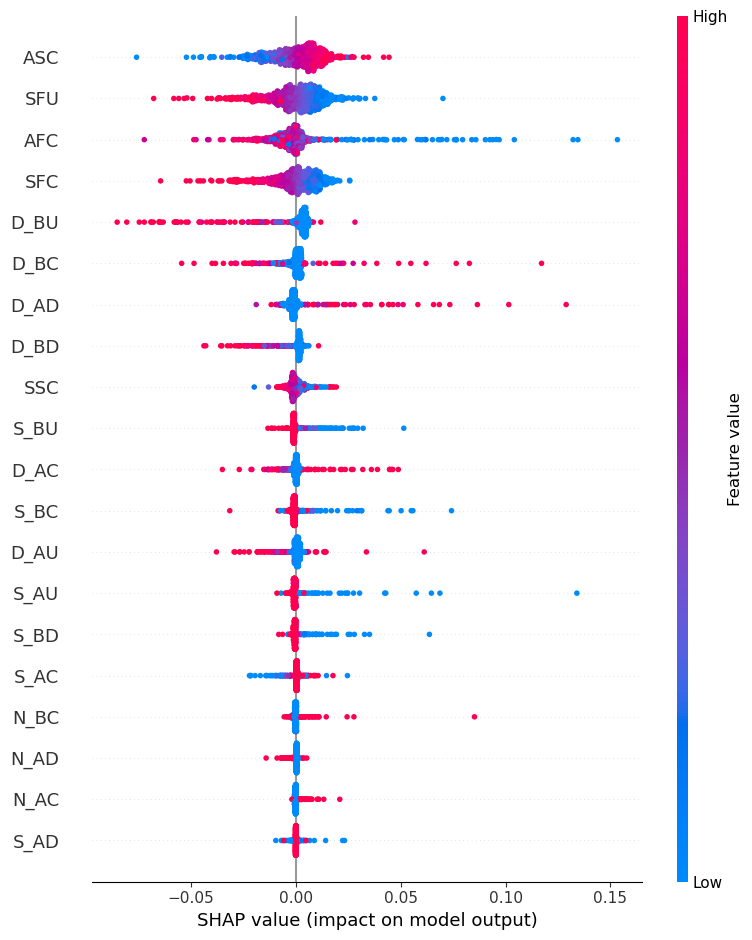

SHAP Summary for timestep 2


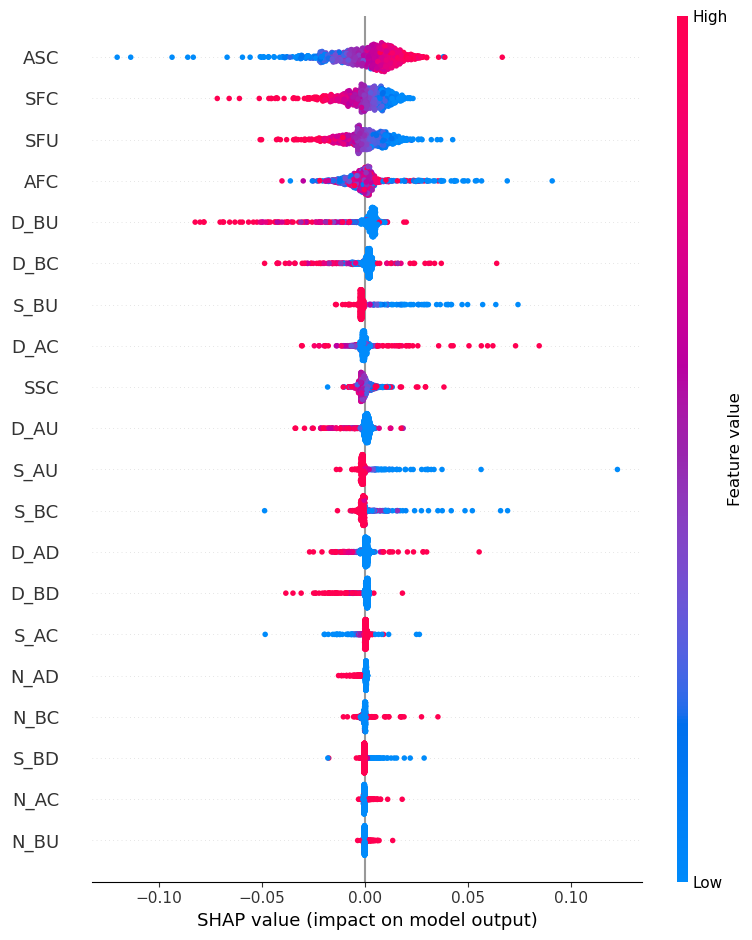

SHAP Summary for timestep 3


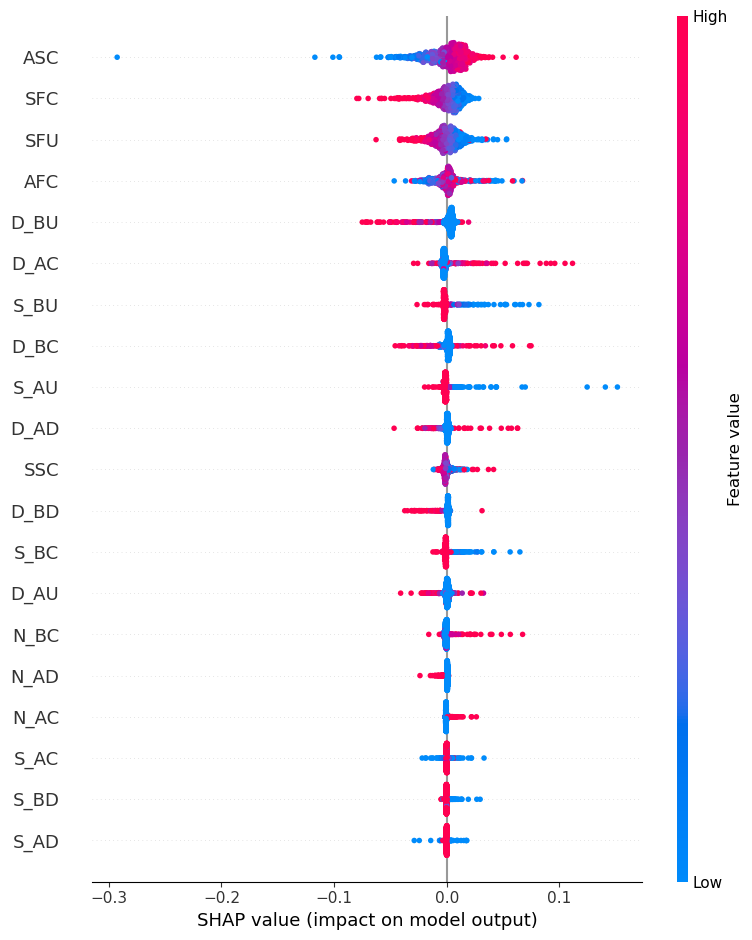

SHAP Summary for timestep 4


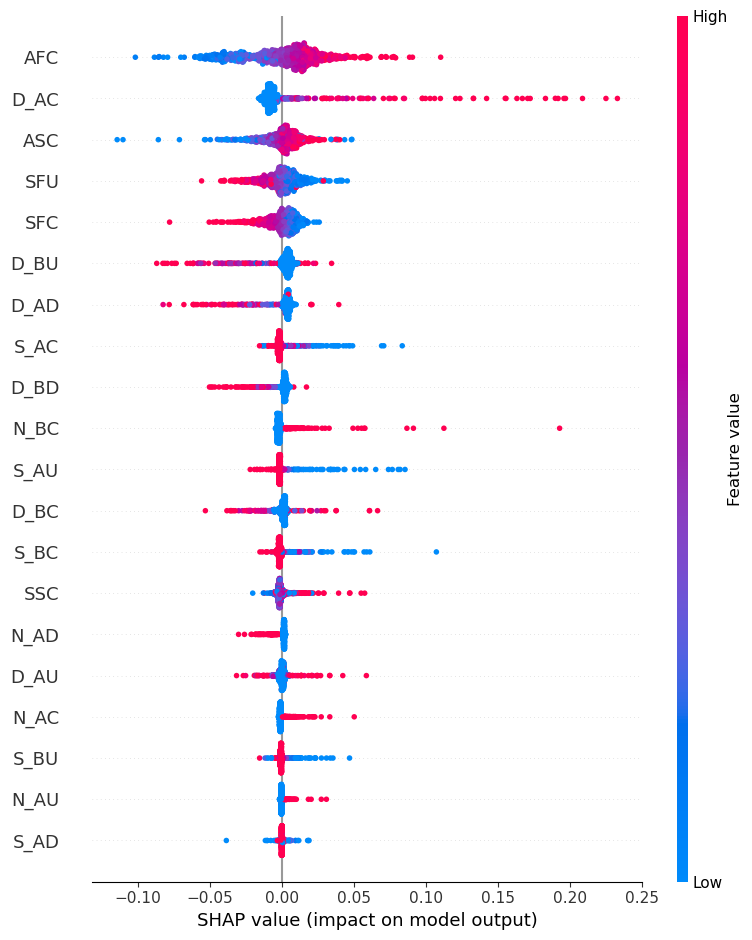

SHAP Summary for timestep 5


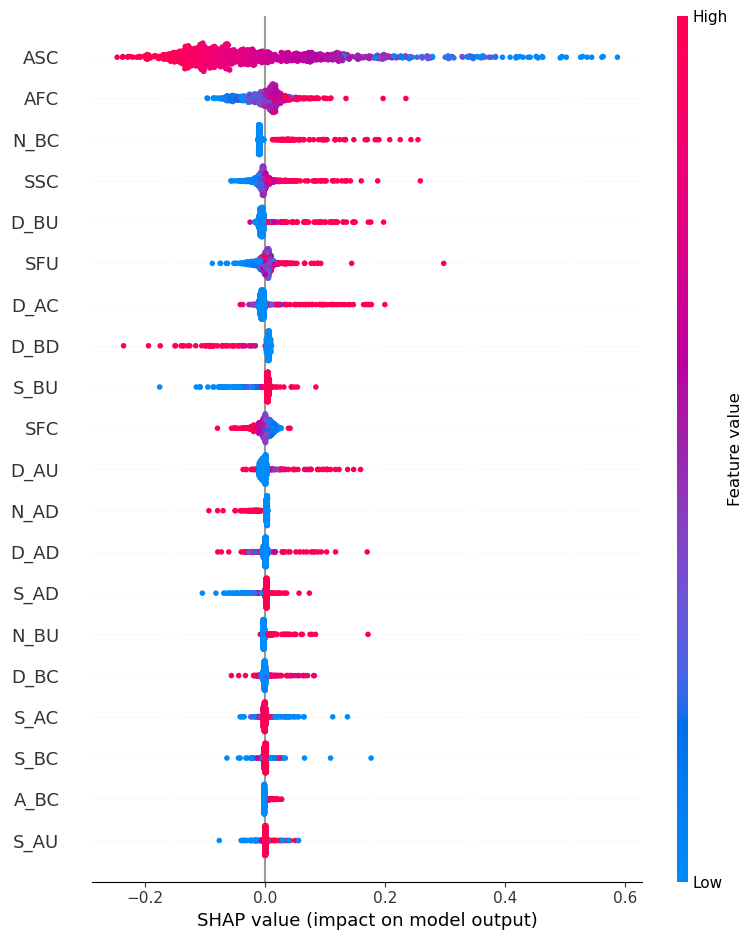

In [11]:
import shap
import numpy as np
import matplotlib.pyplot as plt

explainer = shap.DeepExplainer(model,train_X)
shap_values = explainer.shap_values(train_X)

# Get variable names
feature_names_no_digits = [''.join([i for i in name if not i.isdigit()]) for name in feature_names]
unique_feature_names = []
for name in feature_names_no_digits:
    if name not in unique_feature_names:
        unique_feature_names.append(name)

# SHAP results in one example sample
shap.initjs()
sample_feature_values = train_X[0]

shap_html = shap.force_plot(explainer.expected_value[0], shap_values[0][0], sample_feature_values, feature_names=unique_feature_names)
display(shap_html)

# Calculate the average feature importance at 5 time period and plot
sample_index = 5 
sample_shap_values_flat = shap_values[0][sample_index].flatten()
sample_feature_values_flat = train_X[sample_index].flatten()

flat_feature_names = [f"{name}_t{t}" for name in unique_feature_names for t in range(train_X.shape[1])]

shap.force_plot(explainer.expected_value[0], sample_shap_values_flat, sample_feature_values_flat, feature_names=flat_feature_names, matplotlib=True)

mean_abs_shap_values = np.abs(shap_values[0]).mean(axis=(0, 1))

sorted_indices = np.argsort(mean_abs_shap_values)[::-1]
sorted_features = np.array(unique_feature_names)[sorted_indices]
sorted_importances = mean_abs_shap_values[sorted_indices]

plt.figure(figsize=(10, len(unique_feature_names)*0.5))
plt.barh(sorted_features, sorted_importances, color='dodgerblue')
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()

# Calculate the average feature importance for each time period and plot
mean_shap_values_per_timestep = np.mean(np.abs(shap_values[0]), axis=0)

for timestep, values in enumerate(mean_shap_values_per_timestep):
    sorted_indices = np.argsort(values)[::-1]
    sorted_features = np.array(unique_feature_names)[sorted_indices]
    sorted_importances = values[sorted_indices]
    
    plt.figure(figsize=(10, len(unique_feature_names)*0.5))
    plt.title(f"Feature importance for timestep {timestep+1}")
    plt.barh(sorted_features[::-1], sorted_importances[::-1], color='skyblue')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.show()

num_timesteps = train_X.shape[1]
for timestep in range(num_timesteps):
    print(f"SHAP Summary for timestep {timestep+1}")
    shap.summary_plot(shap_values[0][:, timestep, :], train_X[:, timestep, :], feature_names=unique_feature_names)